In [116]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import pathlib
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, LeakyReLU, BatchNormalization, Conv1DTranspose, Input, Reshape, InputLayer


if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))


Default GPU Device:/device:GPU:0


# Prepare model for training

In [117]:
import os
import pandas as pd
import numpy as np
xt = np.linspace(448,470,2200)


def process_files(path, dest):
    os.chdir(path)
    print(os.getcwd())

    x = np.linspace(448,480,2200)
    for count, f in enumerate(os.listdir()):
        csv_panda =  pd.read_csv(f, sep='  ')
        xp = csv_panda.iloc[:,0].to_numpy()
        yp = csv_panda.iloc[:,3].to_numpy()
        y = np.interp(x, xp, yp)
        y = y/np.max(y)

        f_name, f_ext = os.path.splitext(f)
        data = np.hstack((np.expand_dims(x,1),np.expand_dims(y,1)))
        print(data.shape)
        np.savetxt(f"{dest}{f_name}.dsv", data, delimiter='  ')

In [ ]:
directory = 'C:\\CALCXPS\\' # folder for training data
batch_size = 64
process_files('./CTM4XAS_Plots/', directory)


# Generator Model

In [118]:
USE_BATCH_NORM = False
num_input_params = 7 # [Nox, Delta, Udd, Upd, TDq, Dt, Ds]
output_size=(2200, 1)
n_filters=128
n_blocks=2
size_factor = 2**n_blocks
hidden_size = (output_size[0]//size_factor)
model = tf.keras.Sequential()
model.add(InputLayer(input_shape=(1,num_input_params)))
model.add(Dense(units=n_filters*hidden_size))
model.add(LeakyReLU())
model.add(Reshape((hidden_size, n_filters)))
# now we upsample the feature space to
model.add(Conv1DTranspose(filters=n_filters,
                          kernel_size=4,
                          strides=1,
                          padding='same',
                          use_bias=False
                          ))
if USE_BATCH_NORM:
    model.add(BatchNormalization())
    
model.add(LeakyReLU())

nf = n_filters
for i in range(n_blocks):
    nf = nf // 2
    model.add(Conv1DTranspose(filters=nf,
                              kernel_size=5,
                              strides=2,
                              padding='same',
                              use_bias=False
                              ))
    if USE_BATCH_NORM:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())

model.add(Conv1D(filters=output_size[1],
                          kernel_size=5,
                          strides=1,
                          padding='same',
                          use_bias=False,
                          activation='tanh')
                          )

model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1, 70400)          563200    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 1, 70400)          0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 550, 128)          0         
_________________________________________________________________
conv1d_transpose_24 (Conv1DT (None, 550, 128)          65536     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 550, 128)          0         
_________________________________________________________________
conv1d_transpose_25 (Conv1DT (None, 1100, 64)          40960     
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 1100, 64)         

# Training Data

# Prepare model for training

In [130]:
import numpy as np

def convert_file_name_to_params(filename):
    x = [ float(e) for e in re.findall(r'[\d]*[.]\d{1,3}',filename)]
    Nox, Delta, Udd, TDq, Dt, Upd, Ds = (*x, 0)  # At the moment Ds is always zero      
    x = np.array([Nox, Delta, Udd, Upd, TDq, Dt, Ds])
    return x

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, shuffle=True):
        'Initialization'
        
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization      
        X_BATCH = None
        Y_BATCH = None
        
        # Generate data
        for file in list_IDs_temp:
            file_path= file
            csv_panda =  pd.read_csv(file_path, sep='  ', header=None)
            spectrum = csv_panda.iloc[:,1].to_numpy()

            x= convert_file_name_to_params(file_path)
            

            if X_BATCH is None:
                X_BATCH = x
                Y_BATCH = spectrum
            else:
                X_BATCH = np.vstack([X_BATCH, x])
                Y_BATCH = np.vstack([Y_BATCH, spectrum])        
        
        return X_BATCH, np.expand_dims(Y_BATCH, axis=2) 

    


dataset = tf.data.Dataset.list_files(f"{directory}*.*")
from os import listdir
from os.path import isfile, join

onlyfiles = [join(directory, f) for f in listdir(directory) if isfile(join(directory, f))]
num_files = len(onlyfiles)
num_training_files = int(np.round(num_files * 95/100));
num_validation_files = int(np.round(num_files * 5/100));
print('num files', num_files)
print('validation files', num_validation_files)

indices = np.random.permutation(num_files)
training_idx, validaton_idx = indices[:num_training_files], indices[num_training_files:]
training_files, validation_files = [onlyfiles[i] for i in training_idx], [onlyfiles[i] for i in validaton_idx]

# Generators
training_generator = DataGenerator(training_files, batch_size)
validation_generator = DataGenerator(validation_files, batch_size)
print('samples', len(training_generator))
    
    
print(len(validation_files))
for step, (x_batch_train, y_batch_train) in enumerate(validation_generator):
    print(x_batch_train.shape)
    print(x_batch_train)
    print(x_batch_train[3][4])
    
    print('x', model(x_batch_train).shape)
    print(y_batch_train.shape)
    
    
    break

num files 4451
validation files 223
samples 69
0


In [131]:
validaton_idx

array([], dtype=int32)

# Training

In [121]:
# for layer in model.layers:
#   layer.trainable = True
#   if isinstance(layer, BatchNormalization):
#       print("is instance")
#       print(layer)
#       layer.trainable = False
      
# Instantiate an optimizer to train the model.
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.005)
     

# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

model.compile(optimizer=optimizer, loss=loss_fn)




Start of epoch 0


C:\Users\barbo\.conda\envs\tensorflow_gpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Training loss (for one batch) at step 0: 0.000735
Seen so far: 64 samples
Training loss (for one batch) at step 10: 0.000843
Seen so far: 704 samples
Training loss (for one batch) at step 20: 0.000636
Seen so far: 1344 samples
Training loss (for one batch) at step 30: 0.001229
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 0.000769
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 0.000895
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 0.000591
Seen so far: 3904 samples
INFO:tensorflow:Assets written to: saved_model/my_model\assets


Start of epoch 1


C:\Users\barbo\.conda\envs\tensorflow_gpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Training loss (for one batch) at step 0: 0.000759
Seen so far: 64 samples
Training loss (for one batch) at step 10: 0.000771
Seen so far: 704 samples
Training loss (for one batch) at step 20: 0.000593
Seen so far: 1344 samples
Training loss (for one batch) at step 30: 0.001012
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 0.000632
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 0.000820
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 0.000487
Seen so far: 3904 samples
INFO:tensorflow:Assets written to: saved_model/my_model\assets


Start of epoch 2


C:\Users\barbo\.conda\envs\tensorflow_gpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Training loss (for one batch) at step 0: 0.000617
Seen so far: 64 samples
Training loss (for one batch) at step 10: 0.000681
Seen so far: 704 samples
Training loss (for one batch) at step 20: 0.000568
Seen so far: 1344 samples
Training loss (for one batch) at step 30: 0.001017
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 0.000660
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 0.000846
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 0.000497
Seen so far: 3904 samples
INFO:tensorflow:Assets written to: saved_model/my_model\assets


Start of epoch 3


C:\Users\barbo\.conda\envs\tensorflow_gpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Training loss (for one batch) at step 0: 0.000593
Seen so far: 64 samples
Training loss (for one batch) at step 10: 0.000668
Seen so far: 704 samples
Training loss (for one batch) at step 20: 0.000550
Seen so far: 1344 samples
Training loss (for one batch) at step 30: 0.000994
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 0.000551
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 0.000800
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 0.000467
Seen so far: 3904 samples
INFO:tensorflow:Assets written to: saved_model/my_model\assets


Start of epoch 4


C:\Users\barbo\.conda\envs\tensorflow_gpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Training loss (for one batch) at step 0: 0.000574
Seen so far: 64 samples
Training loss (for one batch) at step 10: 0.000673
Seen so far: 704 samples
Training loss (for one batch) at step 20: 0.000545
Seen so far: 1344 samples
Training loss (for one batch) at step 30: 0.000981
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 0.000598
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 0.000815
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 0.000479
Seen so far: 3904 samples
INFO:tensorflow:Assets written to: saved_model/my_model\assets


Start of epoch 5


C:\Users\barbo\.conda\envs\tensorflow_gpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Training loss (for one batch) at step 0: 0.000585
Seen so far: 64 samples
Training loss (for one batch) at step 10: 0.000677
Seen so far: 704 samples
Training loss (for one batch) at step 20: 0.000528
Seen so far: 1344 samples
Training loss (for one batch) at step 30: 0.000958
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 0.000543
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 0.000780
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 0.000466
Seen so far: 3904 samples
INFO:tensorflow:Assets written to: saved_model/my_model\assets


Start of epoch 6


C:\Users\barbo\.conda\envs\tensorflow_gpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Training loss (for one batch) at step 0: 0.000556
Seen so far: 64 samples
Training loss (for one batch) at step 10: 0.000658
Seen so far: 704 samples
Training loss (for one batch) at step 20: 0.000519
Seen so far: 1344 samples
Training loss (for one batch) at step 30: 0.000951
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 0.000591
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 0.000791
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 0.000474
Seen so far: 3904 samples
INFO:tensorflow:Assets written to: saved_model/my_model\assets


Start of epoch 7


C:\Users\barbo\.conda\envs\tensorflow_gpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Training loss (for one batch) at step 0: 0.000586
Seen so far: 64 samples
Training loss (for one batch) at step 10: 0.000643
Seen so far: 704 samples
Training loss (for one batch) at step 20: 0.000527
Seen so far: 1344 samples
Training loss (for one batch) at step 30: 0.000960
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 0.000559
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 0.000750
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 0.000460
Seen so far: 3904 samples
INFO:tensorflow:Assets written to: saved_model/my_model\assets


Start of epoch 8


C:\Users\barbo\.conda\envs\tensorflow_gpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Training loss (for one batch) at step 0: 0.000541
Seen so far: 64 samples
Training loss (for one batch) at step 10: 0.000633
Seen so far: 704 samples
Training loss (for one batch) at step 20: 0.000500
Seen so far: 1344 samples
Training loss (for one batch) at step 30: 0.000953
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 0.000578
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 0.000764
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 0.000467
Seen so far: 3904 samples
INFO:tensorflow:Assets written to: saved_model/my_model\assets


Start of epoch 9


C:\Users\barbo\.conda\envs\tensorflow_gpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Training loss (for one batch) at step 0: 0.000530
Seen so far: 64 samples
Training loss (for one batch) at step 10: 0.000633
Seen so far: 704 samples
Training loss (for one batch) at step 20: 0.000520
Seen so far: 1344 samples
Training loss (for one batch) at step 30: 0.000913
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 0.000520
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 0.000740
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 0.000432
Seen so far: 3904 samples
INFO:tensorflow:Assets written to: saved_model/my_model\assets


Start of epoch 10


C:\Users\barbo\.conda\envs\tensorflow_gpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Training loss (for one batch) at step 0: 0.000521
Seen so far: 64 samples
Training loss (for one batch) at step 10: 0.000609
Seen so far: 704 samples
Training loss (for one batch) at step 20: 0.000502
Seen so far: 1344 samples
Training loss (for one batch) at step 30: 0.000878
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 0.000529
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 0.000741
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 0.000425
Seen so far: 3904 samples
INFO:tensorflow:Assets written to: saved_model/my_model\assets


Start of epoch 11


C:\Users\barbo\.conda\envs\tensorflow_gpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Training loss (for one batch) at step 0: 0.000514
Seen so far: 64 samples
Training loss (for one batch) at step 10: 0.000601
Seen so far: 704 samples
Training loss (for one batch) at step 20: 0.000515
Seen so far: 1344 samples
Training loss (for one batch) at step 30: 0.000883
Seen so far: 1984 samples
Training loss (for one batch) at step 40: 0.000532
Seen so far: 2624 samples
Training loss (for one batch) at step 50: 0.000722
Seen so far: 3264 samples
Training loss (for one batch) at step 60: 0.000421
Seen so far: 3904 samples
INFO:tensorflow:Assets written to: saved_model/my_model\assets


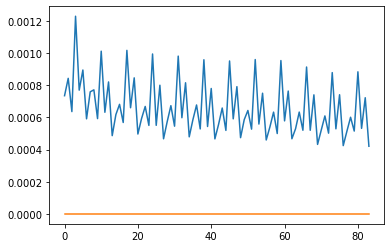

In [132]:

total_loss= []
total_validation = []
epochs = 12
for epoch in range(epochs):
    print("\n\nStart of epoch %d" % (epoch,))

     # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(training_generator):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            output = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, output)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 10 == 0:
            print(
                "Training loss (for one batch) at step %d: %.6f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
            loss_validation = 0
            for step, (x_batch_train, y_batch_train) in enumerate(validation_generator):
                output = model(x_batch_train, training=False)  # Logits for this minibatch
                loss_validation += loss_fn(y_batch_train, output)
            
            total_loss.append(loss_value)
            total_validation.append(loss_validation)
                
            
    model.save('saved_model/Ti2pXPS')

batches = range(0, len(total_loss) )   
plt.plot(batches, total_loss, batches, total_validation)
    


Text(0.5, 0, 'number of batches')

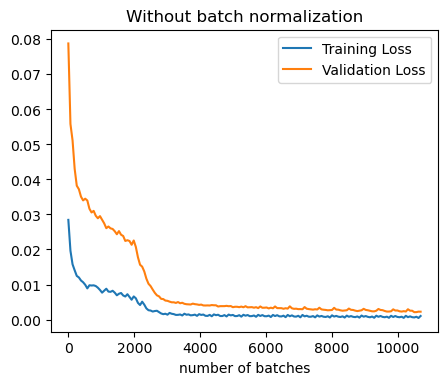

In [125]:
plt.figure(figsize=(5, 4), dpi=100)
batches = np.array(range(0, len(total_loss) ))*64
plt.plot(batches, total_loss, batches, total_validation)

plt.title('Without batch normalization')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('number of batches')